
<a href="https://colab.research.google.com/drive/14hL8nwq4ZFf6A_oB936jXADloFVH5fiR?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Deep Learning image search

**Image search engines:**
Generally speaking, search engine usually takes a query and returns results. Image search engines takes an input image as an image query, then the image search engine finds the "similar" images within its indexed database and returns them as the search result. 

**How to measure similarity between two images?**   
- 1- **Pixel space**: One simple way is to measure the euclidean distance between the two images in the pixel space. Accordingly, if two images have common or near values for the corresponding pixels, are then considered "similar". This could work some times, however a dolphin and air plane images with blue backgrounds will be considered similar from pixels point of view, and we do not want that!

- 2- **Feature space**: Another approach is to use the feature space instead of pixel space when computing the euclidean distance between the two images. In other words, project the images into a space where images with similar features are close to each others. In this space dolphins and airplanes are separated despite pixel level similarity.      

**How to get features from images?**  
Now the question is, how to project arbitrary image into a space where similar images based on their complex content are grouped together? Well, the answer is easy! Just use a pre-trained generic network such as InceptionV3 trained on the well known ImageNet Large Scale Visual Recognition Challenge (ILSVRC). The network is trained to classify an input image into one of 1000 different classes. Accordingly, if we feed the network with an arbitrary images, and before the output, we can get a strong feature vector that summarizes the content of the input images. that's it.           

For the image search engine, we are going to use the feature vector generated by the a pre- trained network (InceptionV3 for instance), instead of the naive pixel wise approach.         

**Dataset:**   
In the following examples we used the Caltech 101 dataset. For simplicity, only 9 classes are used: 

`['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']`




**Implementation Steps:**   
- Download the data and convert it into X (images) and y (labels)  
- Randomize the data and select a subset of the data as the dataset on which we want to conduct the search
- Load the InceptionV3 network with weights and without the top part to get the high level features.
- Compute the feature for all images in the dataset
- For a query image: Compute its feature vector. Loop and find the euclidean distance between the query image features and the dataset features. Return the nearest results.       

Note: if the dataset is very large, more optimized methods can be used to find the nearest candidates to the query image, such as  KDTree and BallTree. 


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# model = VGG16(weights='imagenet', include_top=False)
model = InceptionV3(weights='imagenet', include_top=False)
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________

In [0]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

# Caltech 101

http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [0]:
from urllib.request import urlretrieve
import os
import tarfile
import cv2
import pprint
import operator

In [0]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'

current_directory = os.path.dirname(os.path.realpath('__file__'))
dataset_file_path = current_directory+"/dataset.tgz"
if os.path.exists(dataset_file_path):
    print("Already downloaded.")
else:
    filename, headers = urlretrieve(URL_CALTECH_101_DATA, dataset_file_path)        
print("Done")

Already downloaded.
Done


In [0]:
if (not os.path.exists('./data/')):
    os.makedirs('./data/')
tar = tarfile.open('./dataset.tgz', "r:gz")
tar.extractall(path='./data/')
tar.close()
print("Data extracted")

Data extracted


In [0]:
data_directory = "./data"
categories = os.listdir(data_directory + "/101_ObjectCategories/")
object_images_count_dict = {}
for category in categories:
    object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
print(object_images_count_dict)

[('airplanes', 800), ('Motorbikes', 798), ('BACKGROUND_Google', 468), ('Faces', 435), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107), ('hawksbill', 100), ('grand_piano', 99), ('brain', 98), ('butterfly', 91), ('helicopter', 88), ('menorah', 87), ('kangaroo', 86), ('starfish', 86), ('trilobite', 86), ('sunflower', 85), ('ewer', 85), ('buddha', 85), ('scorpion', 84), ('revolver', 82), ('laptop', 81), ('ibis', 80), ('llama', 78), ('minaret', 76), ('electric_guitar', 75), ('umbrella', 75), ('crab', 73), ('crayfish', 70), ('cougar_face', 69), ('dragonfly', 68), ('flamingo', 67), ('dalmatian', 67), ('ferry', 67), ('lotus', 66), ('dolphin', 65), ('elephant', 64), ('soccer_ball', 64), ('euphonium', 64), ('stop_sign', 64), ('joshua_tree', 64), ('schooner', 63), ('chair', 62), ('lamp', 61), ('yin_yang', 60), ('wheelchair', 59), ('cellphone', 59), ('stegosaurus', 59), ('rhino', 59), ('cup', 57), ('sea_horse', 57), ('

In [0]:
len(object_images_count_dict)

102

In [0]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data not found!")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correct colors
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [0]:
i = 0
X = np.ndarray((10000, 200, 300, 3), dtype=np.uint8)
Y = []

selected_cls = ['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']

for category,_ in object_images_count_dict:
    if category in selected_cls:
      for image in get_images(category, data_directory):
          if not image.endswith('.jpg'):
              continue
          X[i] = read_image(image)
          Y.insert(i,category) 
          i += 1
      print(str(i+1) + "  " + category)


X = X[:i]
print("Done")


801  airplanes
1599  Motorbikes
2034  Faces
2469  Faces_easy
2669  Leopards
2792  car_side
2891  grand_piano
2989  brain
3080  butterfly
Done


In [0]:
X.shape

(3079, 200, 300, 3)

In [0]:
Y[0]

'airplanes'

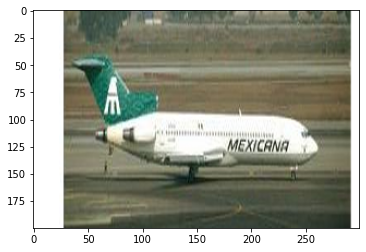

In [0]:
plt.imshow(X[0])

In [0]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([4, 4, 4, ..., 6, 6, 6])

In [0]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [0]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['airplanes'], dtype='<U11')

In [0]:
# randomize and select sample data
x_train, x_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.3, random_state=42)

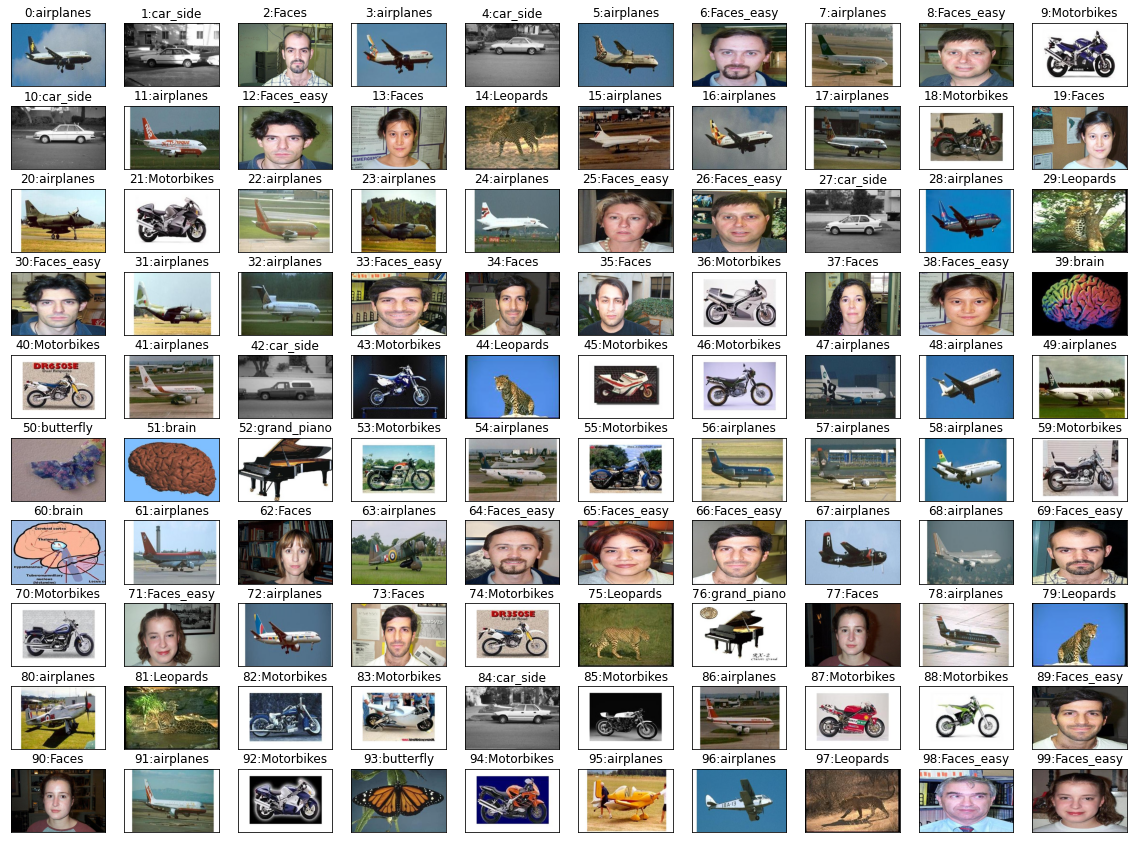

In [0]:
fig=plt.figure(figsize=(20, 15))
columns = 10
rows = 10
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[i])
    t = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    plt.title(str(i) +":"+ t)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
for i in range(len(selected_cls)):
  print(i , label_encoder.inverse_transform([i])[0])

0 Faces
1 Faces_easy
2 Leopards
3 Motorbikes
4 airplanes
5 brain
6 butterfly
7 car_side
8 grand_piano


In [0]:
data_set = preprocess_input(x_test)

In [0]:
feats = model.predict(data_set)
feats = np.squeeze(feats)
print(feats.shape)

(924, 4, 8, 2048)


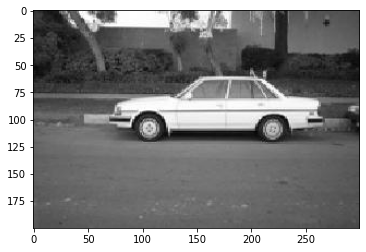

In [0]:
Q_id = 10
Query_image = x_test[Q_id]
plt.imshow(Query_image)
Query_image = preprocess_input(Query_image)
Query_feats = model.predict(np.expand_dims(Query_image, axis=0))
Query_feats = Query_feats.squeeze()

In [0]:
# Euclidean distance
results = []
for i in range(feats.shape[0]):
  d = np.linalg.norm(feats[i].flatten() - Query_feats.flatten())
  results.append((d, i))

results = sorted(results)

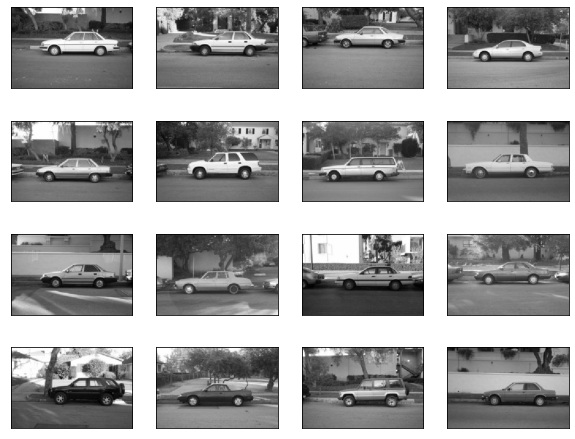

In [0]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# Euclidean distance
results = []
for i in range(x_test.shape[0]):
  d = np.linalg.norm(x_test[i].flatten() - x_test[Q_id].flatten())
  results.append((d, i))

results = sorted(results)

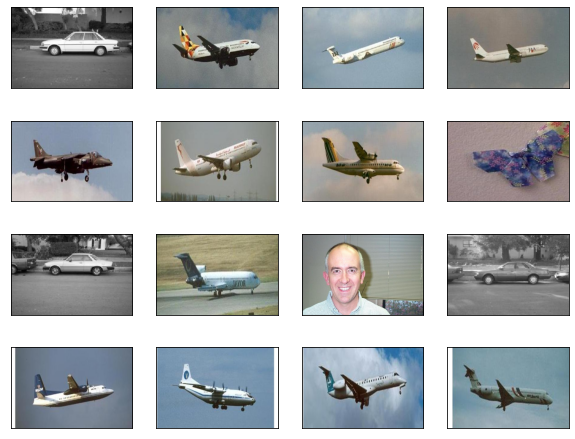

In [0]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
# http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
def plot_dataset(X, y, X_embedded, min_dist=10.0):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(frameon=False)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
    
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            res = cv2.resize(X[i], dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(res), X_embedded[i])
            ax.add_artist(imagebox)

In [0]:
n_tsne = 300

In [0]:
tsne_feats = np.reshape(feats, (feats.shape[0], feats.shape[1]*feats.shape[2]*feats.shape[3]))[:n_tsne]
tsne_f = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_feats)
print(tsne_f.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 1.129s...
[t-SNE] Computed neighbors for 300 samples in 13.870s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 63.082905
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 72.4958954, gradient norm = 0.4425278 (50 iterations in 0.103s)
[t-SNE] Iteration 100: error = 73.9677353, gradient norm = 0.4329817 (50 iterations in 0.102s)
[t-SNE] Iteration 150: error = 72.6652832, gradient norm = 0.4701275 (50 iterations in 0.112s)
[t-SNE] Iteration 200: error = 70.4007416, gradient norm = 0.4626413 (50 iterations in 0.111s)
[t-SNE] Iteration 250: error = 70.7672729, gradient norm = 0.4566679 (50 iterations in 0.098s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.767273
[t-SNE] Iteration 300: error = 0.6579108, gradient norm = 0.0058505 (50 iterations in 0.088s)
[t-SNE] Iteration 350: error = 0.5569179, gradient norm = 0.0018187

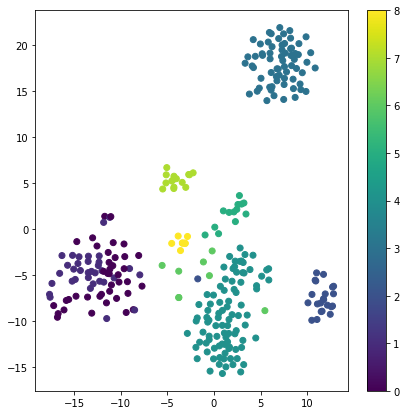

In [0]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], c=c)

plt.colorbar()
plt.show()

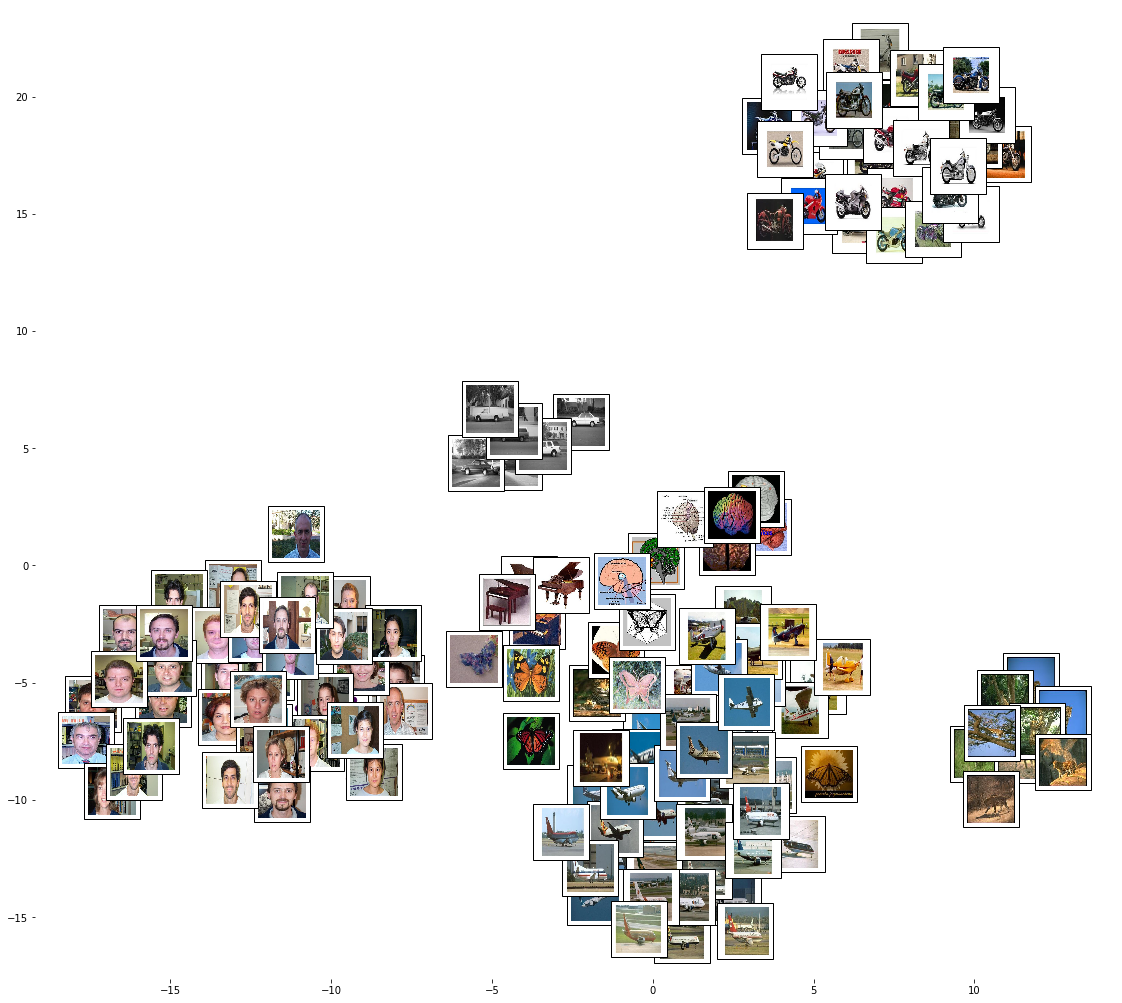

In [0]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_f[:n_tsne], min_dist=1.0)

In [0]:
tsne_pix = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))[:n_tsne]
tsne_p = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_pix)   
print(tsne_p.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 2.770s...
[t-SNE] Computed neighbors for 300 samples in 36.612s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 11641.979900
[t-SNE] Computed conditional probabilities in 0.033s
[t-SNE] Iteration 50: error = 67.1933823, gradient norm = 0.5079318 (50 iterations in 0.095s)
[t-SNE] Iteration 100: error = 69.0528717, gradient norm = 0.4933434 (50 iterations in 0.105s)
[t-SNE] Iteration 150: error = 67.0691223, gradient norm = 0.4913525 (50 iterations in 0.101s)
[t-SNE] Iteration 200: error = 66.7177124, gradient norm = 0.4947395 (50 iterations in 0.107s)
[t-SNE] Iteration 250: error = 70.7609253, gradient norm = 0.4796518 (50 iterations in 0.101s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.760925
[t-SNE] Iteration 300: error = 0.7096472, gradient norm = 0.0057514 (50 iterations in 0.096s)
[t-SNE] Iteration 350: error = 0.6669995, gradient norm = 0.0053

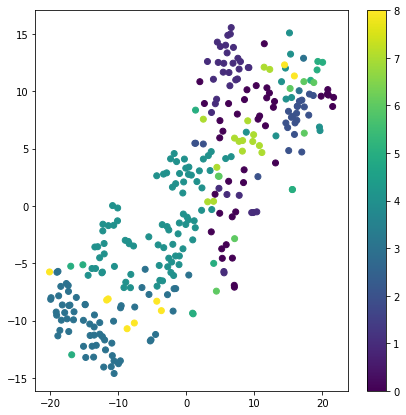

In [0]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_p[:, 0], tsne_p[:, 1], c=c)

plt.colorbar()
plt.show()

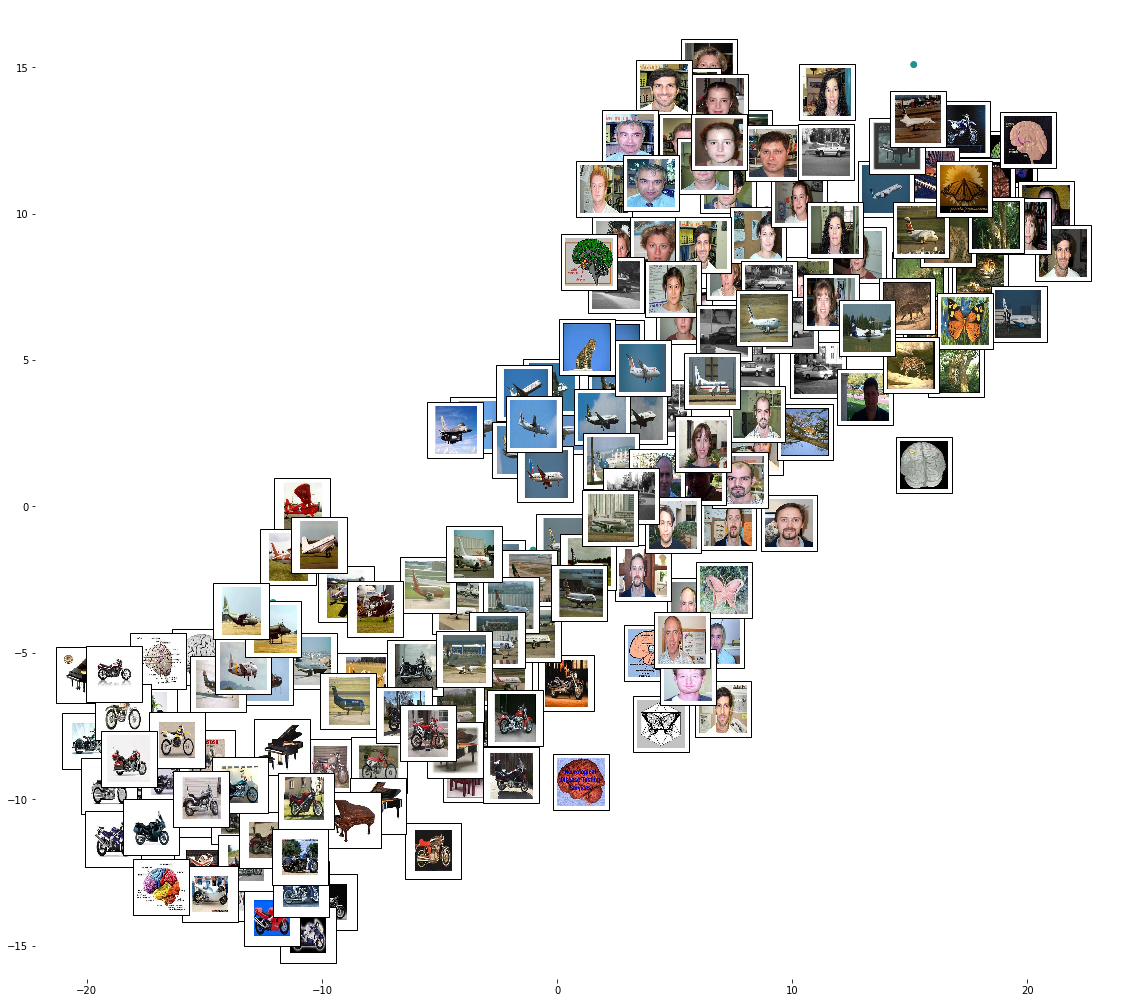

In [0]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_p[:n_tsne], min_dist=1.0)